### Connect to Drive

### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
from keras import backend
from keras.datasets.cifar import load_batch
# isort: off
from tensorflow.python.util.tf_export import keras_export
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Class labels:

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

In [10]:
def load_data():
    dirname = "cifar-10-batches-py"
    path = "./cifar-10-batches-py"

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.empty((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        (
            x_train[(i - 1) * 10000 : i * 10000, :, :, :],
            y_train[(i - 1) * 10000 : i * 10000],
        ) = load_batch(fpath)

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if backend.image_data_format() == "channels_last":
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)

In [22]:
# Download the data
(X_train_val, y_train_val), (X_test, y_test) = load_data()
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), tuple, (10000, 1))

In [24]:
X_train_val = X_train_val[:1000] 
y_train_val = y_train_val[:1000] 
X_test.shape =  X_test[:32]
y_test.shape = y_test[:32]

X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

TypeError: only integer scalar arrays can be converted to a scalar index

### Process data

*I will normalise the images*
*Due to the gray scale is of 255, i will divide per 255*

In [6]:
# Normalize data
X_train_val = X_train_val/255.
X_test = X_test/255.

# Convert the label to categorical (one hot code)
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [7]:
# Split in train and test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=.1, stratify=y_train_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((45000, 32, 32, 3), (45000, 10), (5000, 32, 32, 3), (5000, 10))

In [8]:
# Compare categorical and "default" labels
print('Categorical label:',y_train[0])
print('"Default" label:',np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
"Default" label: 8


### Models metadata

In [9]:
input_shape = X_train.shape[1:]
batch_size = 1024
epochs = 30

### CNN model

In [10]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv1) #we can use max or average pool

    batch1 = tfkl.BatchNormalization()(pool1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(batch1)
    
    pool2 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv3)
    #Finished the feature extraction part

    flattening_layer = tfkl.Flatten(name='Flatten')(pool3) #given an impute and flatter in one dimesion vector
    classifier_layer = tfkl.Dense(
        units=128, 
        name='Classifier', 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=10, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [11]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0     

In [12]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
).history

Epoch 1/30


: 

: 

In [ ]:
model.save("CNN.h5")

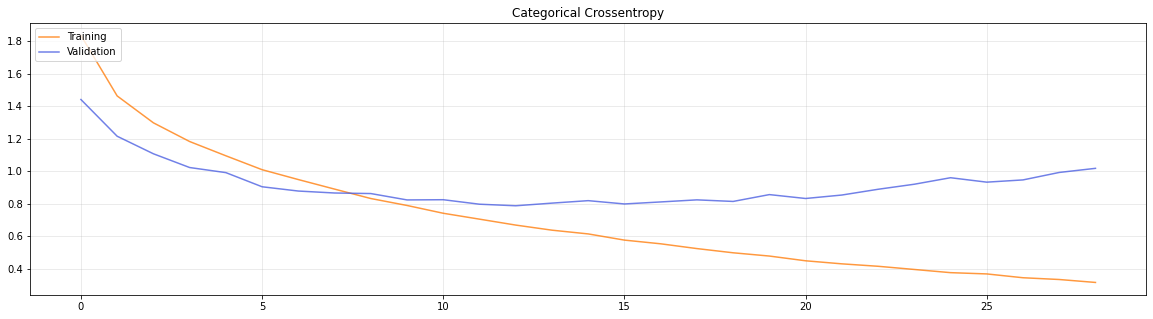

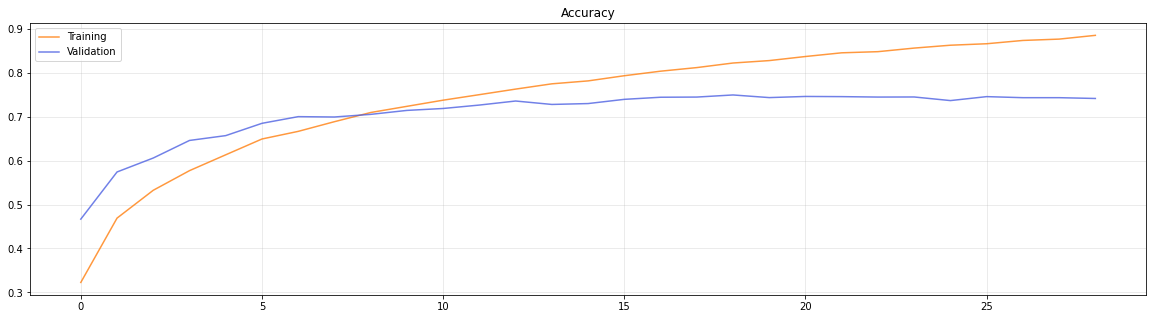

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('CNN')
model = tfk.models.load_model('CNN')

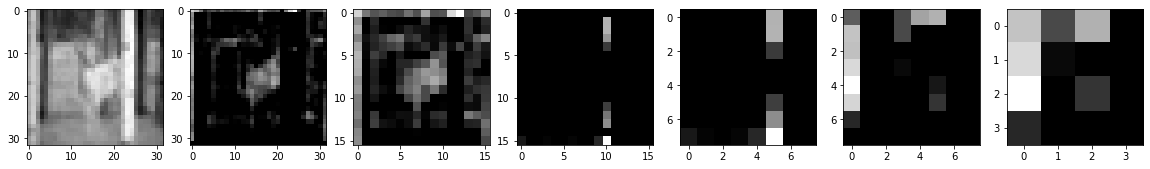

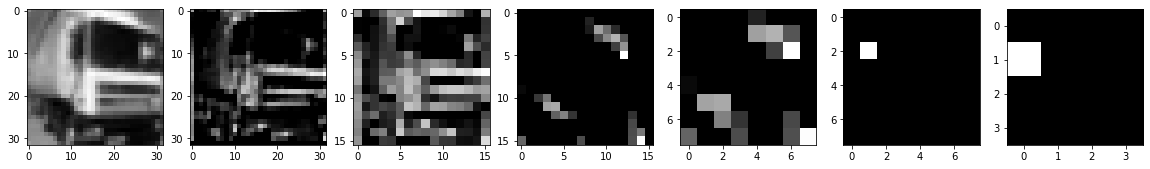

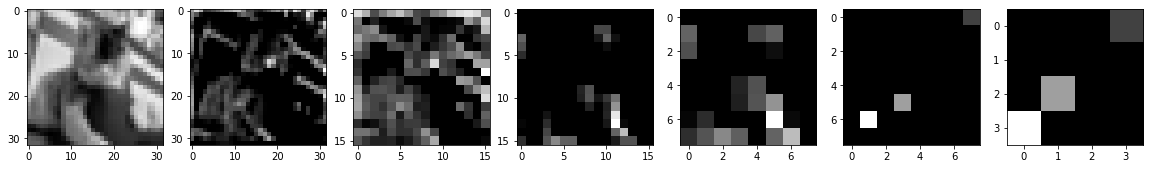

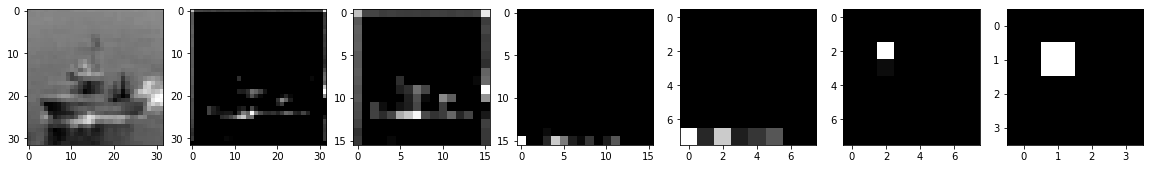

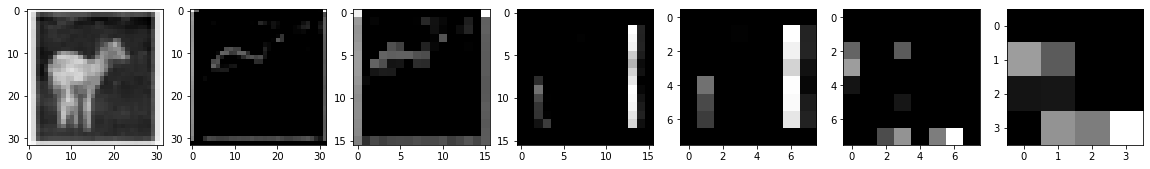

In [ ]:
def plot_latent_filters(model, layers, image):
    fig, axes = plt.subplots(1, len(layers), figsize=(20,5))
    for j,layer in enumerate(layers):
        ax = axes[j]
        ax.imshow(tfk.Sequential(model.layers[:layer]).predict(tf.expand_dims(image,axis=0), verbose=0)[0,:,:,0], cmap='gray')
    plt.show()

layers = [1,2,3,4,5,6,7]
n = 4

for i in range(n):
    plot_latent_filters(model, layers, X_train[random.randint(0,len(X_train))])

In [ ]:
# Predict the test set with the CNN
predictions = model.predict(X_test)
predictions.shape

313/313 [==============================] - 1s 3ms/step


(10000, 10)

[2.3481773e-05 1.9514600e-05 2.2470189e-02 1.7478491e-01 4.2277873e-03
 2.8103504e-02 7.7009928e-01 5.7430218e-05 4.9921560e-05 1.6399307e-04]


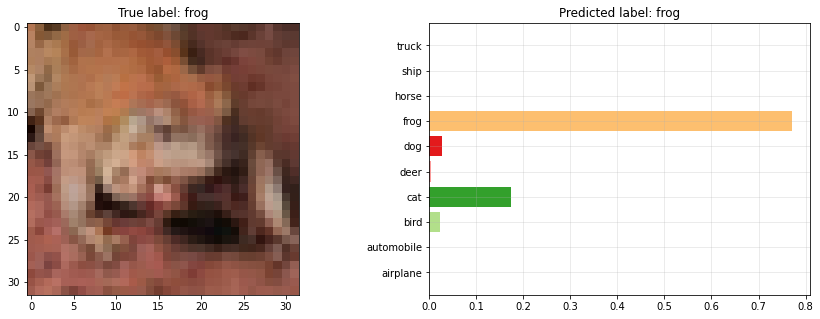

In [ ]:
# Plot the target images and the predictions
prediction_index = 5

print(predictions[prediction_index])

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(y_test[prediction_index])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()

# Classification metrics
## Binary classification

<div>
<img src="https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg" width="400"/>
</div>

##$Accuracy$ = $\frac{TP+TN}{TP+FP+TN+FN}$

##$Precision$ = $\frac{TP}{TP+FP}$

##$Recall$ = $\frac{TP}{TP+FN}$

##$F1$ = $2\frac{precision \cdot recall}{precision+recall}$

## Categorical classification (Macro averaging)


<div>
<img src="https://www.researchgate.net/profile/Frank-Krueger-2/publication/314116591/figure/fig7/AS:614085901185031@1523420896093/Confusion-matrix-for-multi-class-classification-The-confusion-matrix-of-a_W640.jpg" width="700"/>
</div>


##$Accuracy$ = $\frac{diag(CM)}{sum(CM)}$

##$Precision_k$ = $\frac{TP_k}{TP_k+FP_k}$

##$Precision$ = $\frac{\sum_k^n precision_k}{n}$

##$Recall_k$ = $\frac{TP_k}{TP_k+FN_k}$

##$Recall$ = $\frac{\sum_k^n recall_k}{n}$

##$F1$ = $2\frac{precision \cdot recall}{precision+recall}$

Accuracy: 0.7458
Precision: 0.7445
Recall: 0.7458
F1: 0.7443


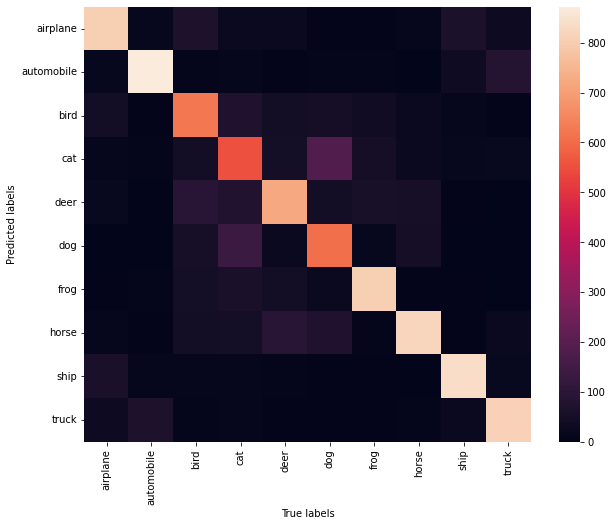

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

What about "deep" learning?

574710816/574710816 [==============================] - 18s 0us/step


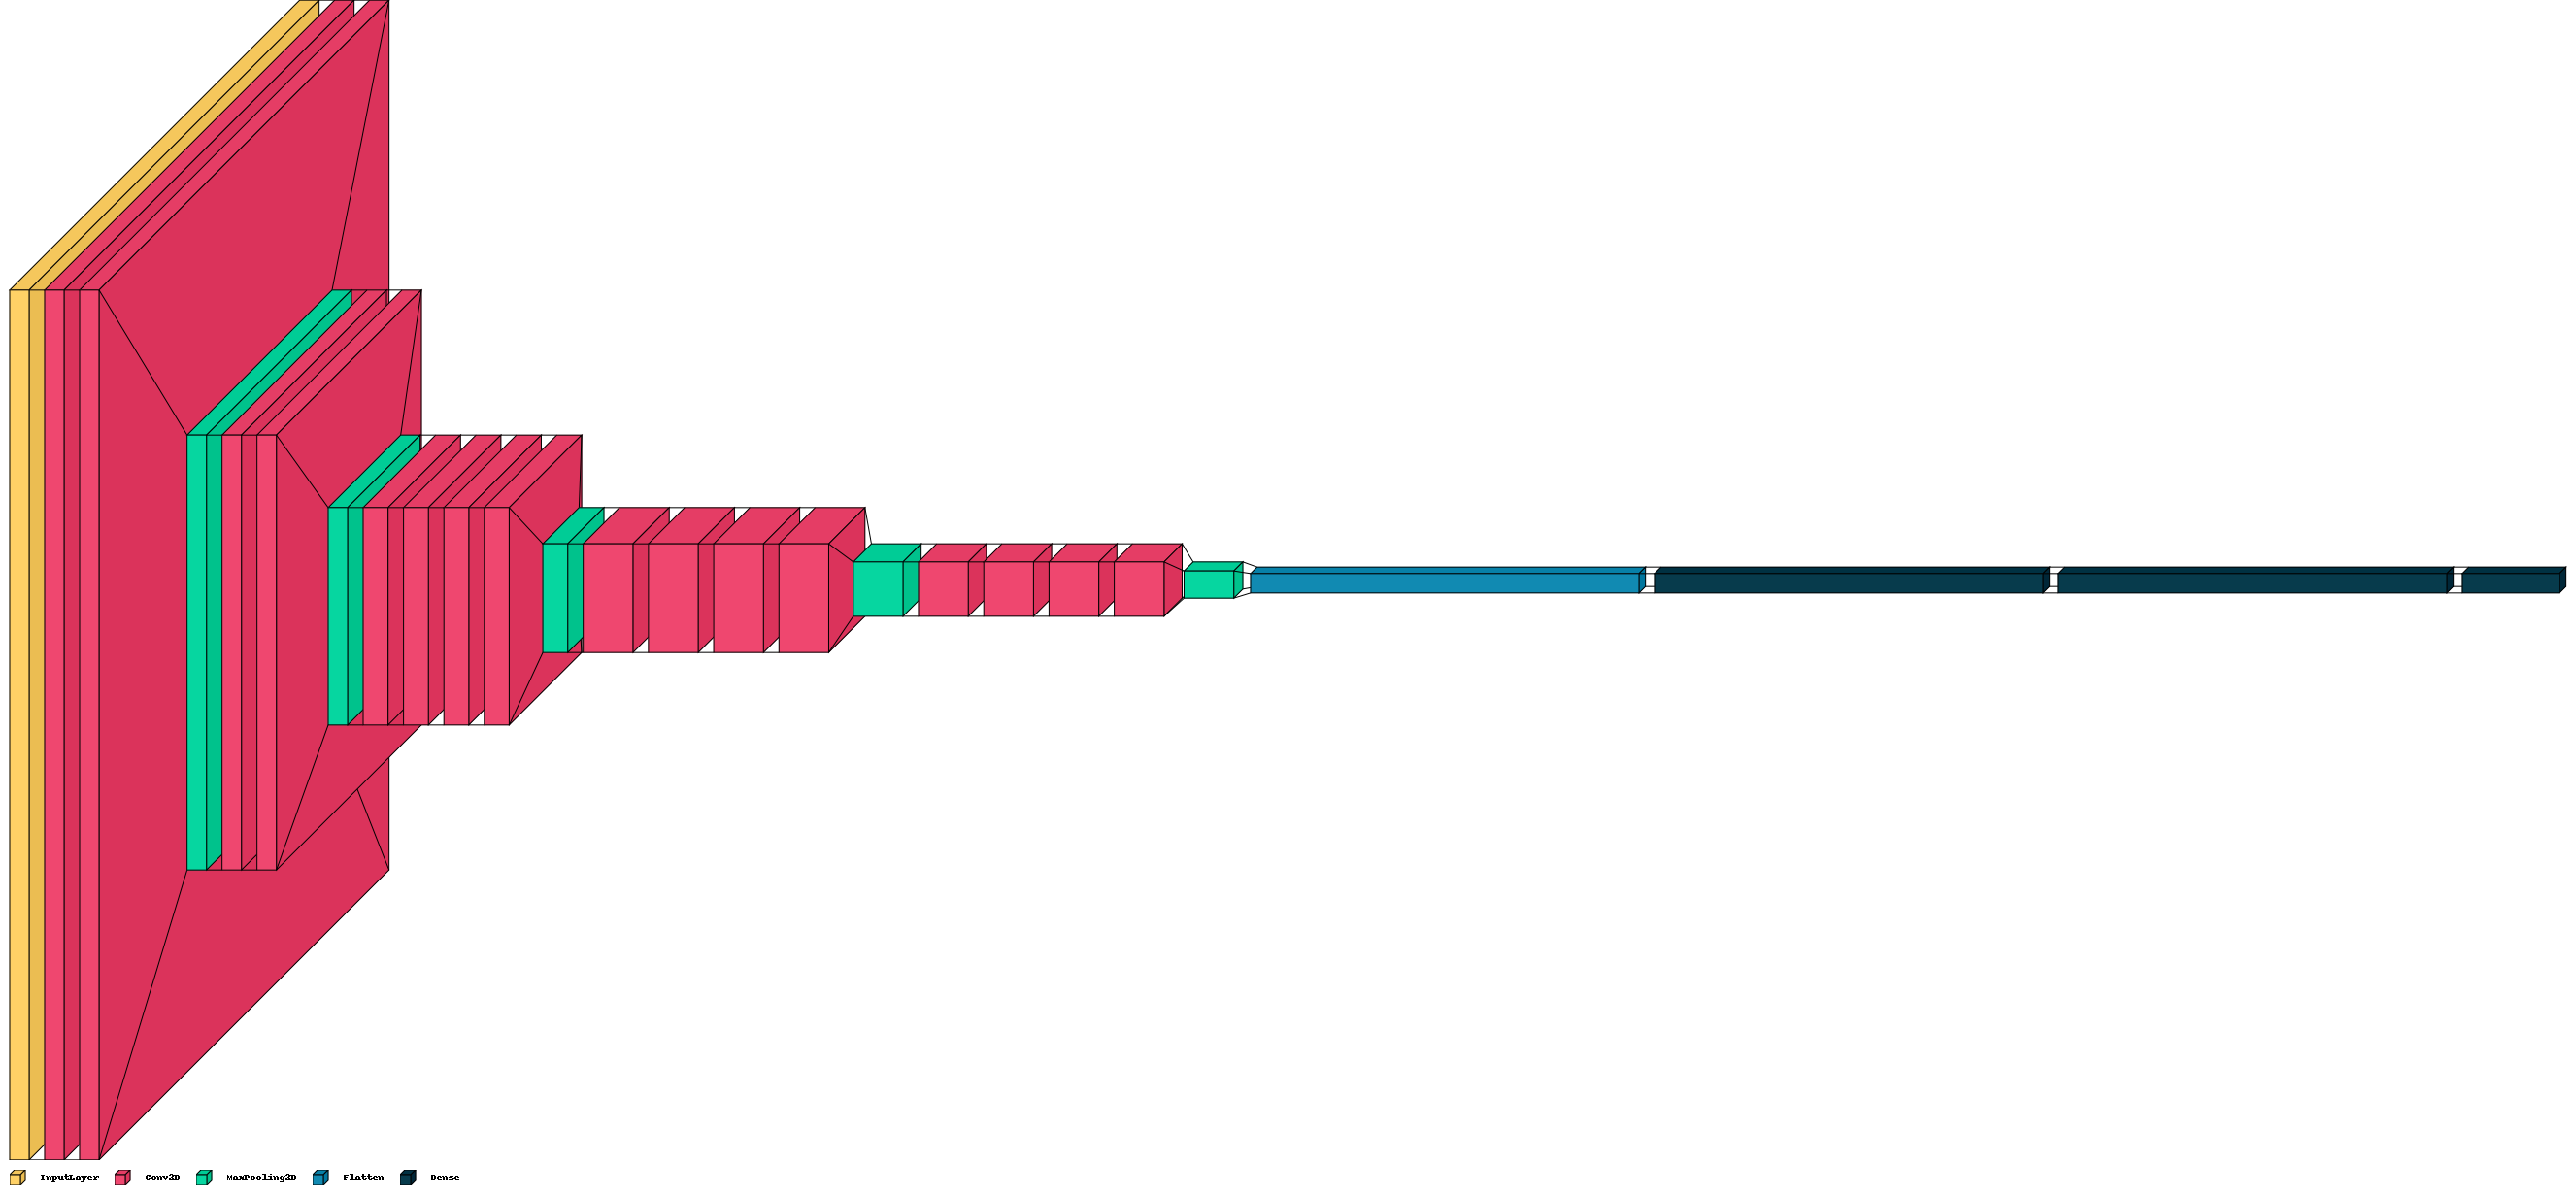

In [ ]:
# Download and plot VGG19
vgg = tfk.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
visualkeras.layered_view(vgg, legend=True, spacing=16, scale_xy=4)

96112376/96112376 [==============================] - 3s 0us/step


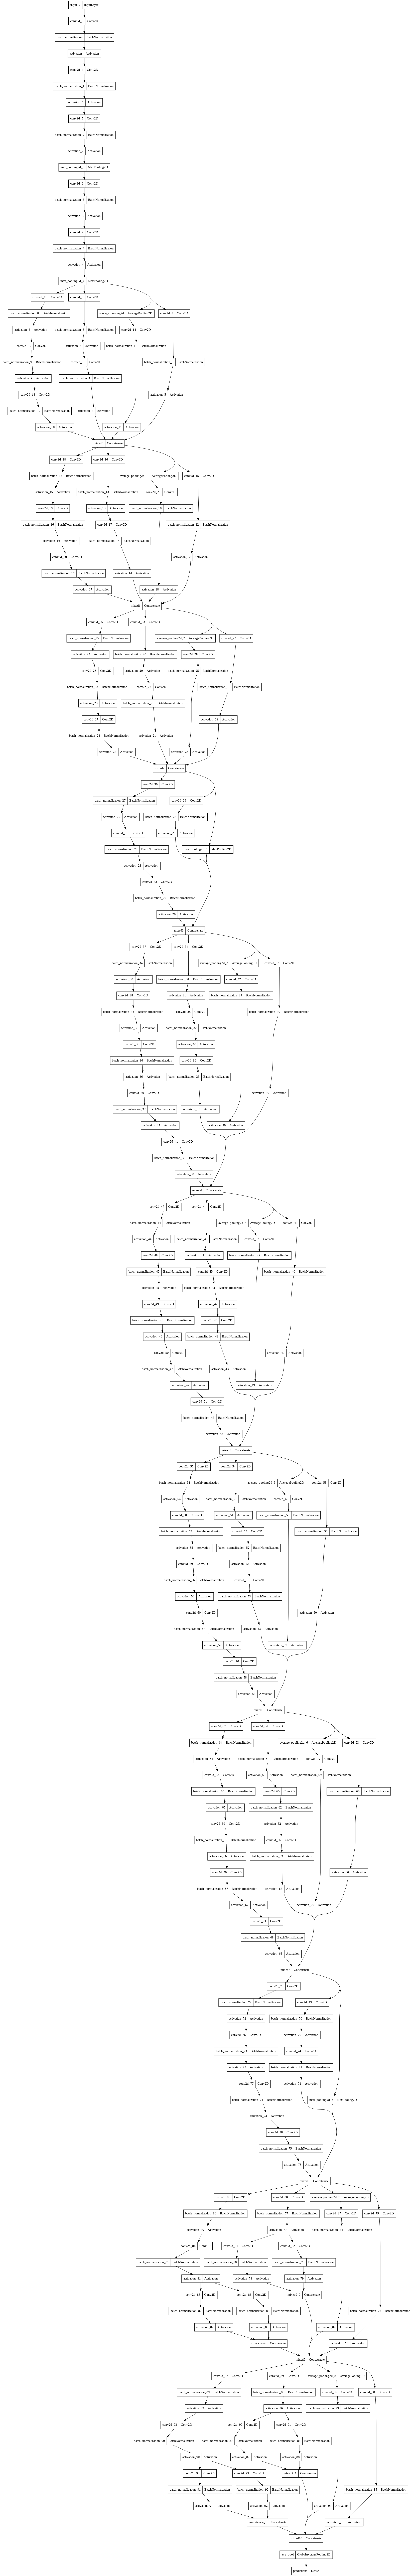

In [ ]:
# Download and plot InceptionV3
inception = tfk.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
tfk.utils.plot_model(inception)